In [1]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import chain
from itertools import groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


To start with lets bring in our import / encode / decode functions from last time.

In [3]:
BEATS_PER_BAR = 4 # beats per bar
DIVISIONS_PER_QUARTER = 4 # i.e. 4 beats per bar and 4 divisions per beat gives 16 divisions per bar
MIDI_NOTE_COUNT = 128
MAX_NOTE_DUR = (8*BEATS_PER_BAR*DIVISIONS_PER_QUARTER)
SEPARATOR_IDX = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)
SOS = '<|sos|>' # Start of sequence
EOS = '<|eos|>' # End of sequence
SEP = '<|sep|>' # End of timestep (required for polyphony). Note index -1
PAD = '<|pad|>' # Padding to ensure blocks are the same size
 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKENS = [SOS, EOS, PAD, SEP]
MIDI_NOTE_COUNT = 128
NOTE_TOKENS = [f'n{i}' for i in range(MIDI_NOTE_COUNT)]
DURATION_SIZE = 8 * BEATS_PER_BAR * DIVISIONS_PER_QUARTER + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DURATION_TOKENS = [f'd{i}' for i in range(DURATION_SIZE)]
NOTE_START, NOTE_END = NOTE_TOKENS[0], NOTE_TOKENS[-1]
DURATION_START, DURATION_END = DURATION_TOKENS[0], DURATION_TOKENS[-1]
ALL_TOKENS = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
ALL_TOKENS[0:8]
TIMESIG = f'{BEATS_PER_BAR}/4'
block_size = 8 # Bigger block size for WaveNet
class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def sos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def pad_idx(self): return self.stoi[PAD]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.stoi[DURATION_END]+1)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1
    @property
    def size(self): return len(self.itos)

def stream_to_sparse_enc(stream_score, note_size=MIDI_NOTE_COUNT, sample_freq=DIVISIONS_PER_QUARTER, max_note_dur=MAX_NOTE_DUR):    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (MusicAutobot author:) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq) + 1
    sparse_score = np.zeros((max_timestep, len(stream_score.parts), note_size), dtype=np.int32)

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx, part in enumerate(stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by timestep (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for note in notes_sorted:
            if note is not None:
                pitch, timestep, duration = note
                clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration
                sparse_score[timestep, idx, pitch] = clamped_duration
    
    return sparse_score

# Pass in the 'one-hot' encoded numpy score
def sparse_to_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0:
                encoded_timesteps.append([SEPARATOR_IDX, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([SEPARATOR_IDX, final_wait_count]) # add trailing rests

    return np.array(encoded_timesteps).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_position_enc(timestep, note_range=PIANO_RANGE):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument, pitch = active_note_idx
        duration = timestep[instrument, pitch]
        if pitch >= note_min and pitch < note_max:
            note_data.append([pitch, duration, instrument])
        return note_data
    
    active_note_idxs = zip(*timestep.nonzero())
    encoded_notes = reduce(encode_note_data, active_note_idxs, [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)

    # Dropping instrument information for simplicity.
    # MusicAutobot allows different encoding schemes which include instrument number and split pitch into class / octave.
    return [n[:2] for n in sorted_notes]

def position_to_idx_enc(note_position_score, vocab):
    note_idx_score = note_position_score.copy()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.duration_range
    
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += np.array([note_min_idx, dur_min_idx])
    
    prefix =  np.array([vocab.sos_idx])
    padding = np.full((block_size - 1), vocab.pad_idx)
    suffix = np.array([vocab.eos_idx])

    return np.concatenate([padding, prefix, note_idx_score.reshape(-1), suffix])

def import_midi_file(file_path):
    midifile = m21.midi.MidiFile()
    if isinstance(file_path, bytes):
        midifile.readstr(file_path)
    else:
        midifile.open(file_path)
        midifile.read()
        midifile.close()
    return midifile

def midifile_to_stream(midifile): 
    return m21.midi.translate.midiFileToStream(midifile)

def midifile_to_idx_score(file_path, vocab):
    midifile = import_midi_file(file_path)
    stream = midifile_to_stream(midifile)
    sparse_score = stream_to_sparse_enc(stream)
    note_pos_score = sparse_to_position_enc(sparse_score)
    return position_to_idx_enc(note_pos_score, vocab)

# Combining notes with different durations into a single chord may overwrite conflicting durations.
def group_notes_by_duration(notes):
    get_note_quarter_length = lambda note: note.duration.quarterLength
    sorted_notes = sorted(notes, key=get_note_quarter_length)
    return [list(g) for k,g in groupby(sorted_notes, get_note_quarter_length)]

def sparse_instrument_to_stream_part(sparse_instrument_score, step_duration):
    part = m21.stream.Part()
    part.append(m21.instrument.Piano())
    
    for t_idx, pitch_values in enumerate(sparse_instrument_score):

        def decode_sparse_note(notes, pitch_index):
            note = m21.note.Note(pitch_index)
            quarters = sparse_instrument_score[t_idx, pitch_index]
            note.duration = m21.duration.Duration(float(quarters) * step_duration.quarterLength)
            notes.append(note)
            return notes
        
        pitch_idxs = np.nonzero(pitch_values)[0]

        if len(pitch_idxs) != 0: 
            notes = reduce(decode_sparse_note, pitch_idxs, [])
            for note_group in group_notes_by_duration(notes):
                note_position = t_idx*step_duration.quarterLength
                if len(note_group) == 1:
                    part.insert(note_position, note_group[0])
                else:
                    chord = m21.chord.Chord(note_group)
                    part.insert(note_position, chord)

    return part

def sparse_to_stream_enc(sparse_score, bpm=120):
    step_duration = m21.duration.Duration(1. / DIVISIONS_PER_QUARTER)
    stream = m21.stream.Score()
    stream.append(m21.meter.TimeSignature(TIMESIG))
    stream.append(m21.tempo.MetronomeMark(number=bpm))

    # Not required here but left as example of options available
    stream.append(m21.key.KeySignature(0))
    
    for inst in range(sparse_score.shape[1]):
        part = sparse_instrument_to_stream_part(sparse_score[:,inst,:], step_duration)
        stream.append(part)
    
    # Again, not required yet but left as example
    stream = stream.transpose(0)
    
    return stream

def position_to_sparse_enc(note_position_score):

    # Add all the separator durations as they denote the elapsed time
    score_length = sum(timestep[1] for timestep in note_position_score if timestep[0] == SEPARATOR_IDX) + 1
    
    # Single instrument as we discarded the instrument information when encoding
    # We will adapt to handle multiple instruments later
    instrument = 0

    def decode_note_position_step(acc, note_pos_step):
        timestep, sparse_score = acc
        note, duration = note_pos_step.tolist()
        if note < SEPARATOR_IDX:  # Skip special token
            return acc
        elif note == SEPARATOR_IDX:  # Time elapsed
            return (timestep + duration, sparse_score)
        else:
            sparse_score[timestep, instrument, note] = duration
            return (timestep, sparse_score)

     # (timesteps, instruments, pitches)
    initial_sparse_score = np.zeros((score_length, 1, MIDI_NOTE_COUNT))
    _, final_sparse_score = reduce(decode_note_position_step, note_position_score, (0, initial_sparse_score))

    return final_sparse_score

# No validation of note position encoding included to keep it simple for now
def idx_to_position_enc(idx_score, vocab):
    
    # Filter out special tokens
    notes_durs_start, notes_durs_end = vocab.note_position_enc_range # range of non-special token values
    notes_durations_idx_score = idx_score[np.where((idx_score >= notes_durs_start) & (idx_score < notes_durs_end))]

    # Reshape into pairs of (note, duration). If odd number of tokens, discard the last token.
    if notes_durations_idx_score.shape[0] % 2 != 0:
        notes_durations_idx_score = notes_durations_idx_score[:-1]

    position_score = notes_durations_idx_score.copy().reshape(-1, 2)
    
    # Shift token index values to note and duration values
    if position_score.shape[0] == 0: 
        return position_score
    else:
        note_min_idx, _ = vocab.note_range
        dur_min_idx, _ = vocab.duration_range
        position_score -= np.array([note_min_idx, dur_min_idx])
        return position_score

def idx_to_stream_enc(idx_score, vocab):
    position_score = idx_to_position_enc(idx_score, vocab)
    sparse_score = position_to_sparse_enc(position_score)
    return sparse_to_stream_enc(sparse_score)

vocab = MusicVocab()

# WaveNet - Progressive fusion of layers

In the previous notebook we only used a single, fully connected, hidden layer in our model.

Because all of the input token embeddings are connected to all of the hidden neurons, we are crushing all of our information together in a single step.

The Wavenet architectecture, on the other hand, progressively fuses sets of tokens in subsequent layers. This allows small features to be gradually merged into larger and broader ones.

We can, for example, take 2 character bigrams of tokens at the input layer, then fuse those into 4-token chunks, then those into 8 token chunks in the final layer.

For that we will need to encode / load out data with a block size of 8.

In [4]:
block_size

8

In [5]:
vg_large_path = Path('data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
len(vg_large_file_names)

3839

In [6]:
def block_encode(file_names, vocab, block_size):
    xs, ys = [], []
    for file_name in file_names:
        file_path = Path(vg_large_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab)
        for i in range(0, len(idx_score) - block_size, 1):
            xs.append(idx_score[i:i+block_size])
            ys.append(idx_score[i+block_size])
    return np.stack(xs), ys # stack xs to create 2D tensor

random.seed(42)
random.shuffle(vg_large_file_names)
n1 = int(0.8 * len(vg_large_file_names))
n2 = int(0.9 * len(vg_large_file_names))
train_filenames = vg_large_file_names[:n1]
valid_filenames = vg_large_file_names[n1:n2]
test_filenames = vg_large_file_names[n2:]

vg_large_block_samples_train = Path(f'data/numpy/vg_large/block_{block_size}_samples_train.npy')
vg_large_block_labels_train = Path(f'data/numpy/vg_large/block_{block_size}_labels_train.npy')
vg_large_block_samples_valid = Path(f'data/numpy/vg_large/block_{block_size}_samples_valid.npy')
vg_large_block_labels_valid = Path(f'data/numpy/vg_large/block_{block_size}_labels_valid.npy')
vg_large_block_samples_test = Path(f'data/numpy/vg_large/block_{block_size}_samples_test.npy')
vg_large_block_labels_test = Path(f'data/numpy/vg_large/block_{block_size}_labels_test.npy')

def load_or_create(file_names, vocab, block_samples, block_labels):
    if block_samples.exists() and block_labels.exists():
        xs, ys = np.load(block_samples, allow_pickle=True), np.load(block_labels, allow_pickle=True)
    else:
        xs, ys = block_encode(file_names, vocab, block_size)
        np.save(block_samples, xs)
        np.save(block_labels, ys)
    return torch.tensor(xs, device=device), torch.tensor(ys, device=device)

Xtrain, Ytrain = load_or_create(train_filenames, vocab, vg_large_block_samples_train, vg_large_block_labels_train)
Xvalid, Yvalid = load_or_create(valid_filenames, vocab, vg_large_block_samples_valid, vg_large_block_labels_valid)
Xtest, Ytest = load_or_create(test_filenames, vocab, vg_large_block_samples_test, vg_large_block_labels_test)

In [7]:
Xtrain.shape, Xtrain.dtype, Ytrain.shape, Ytrain.dtype

(torch.Size([9281963, 8]), torch.int64, torch.Size([9281963]), torch.int64)

In [8]:
Xvalid.shape, Xvalid.dtype, Yvalid.shape, Yvalid.dtype

(torch.Size([1230454, 8]), torch.int64, torch.Size([1230454]), torch.int64)

In [9]:
Xtest.shape, Xtest.dtype, Ytest.shape, Ytest.dtype

(torch.Size([1083728, 8]), torch.int64, torch.Size([1083728]), torch.int64)

Now we need to take our 8-token examples and reshape them into 'bigram' pairs for the first layer, e.g.

(1,2) (3,4) (5,6) (7,8)

We can simply specify the dimension of the last dimension, and the rest will be automatically worked out.

To allow us to insert this step into our `Sequential` model, we need to make a custom class that inherits from `nn.Module`.

In [10]:
class FlattenConsecutive(torch.nn.Module):
  
  def __init__(self, n):
    super(FlattenConsecutive, self).__init__()
    self.n = n
    
  def forward(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) # Remove the time dimension if it is 1
    return x

We can insert our new layer which will cause the input to dilate with a factor of two, to neurons representing 2 tokens.

We can repeat this to dilate to 4-token neurons, then again to 8-token neurons.

PyTorch's BatchNorm1d can handle 3-dimensional inputs. The expected input shape is (N, C, L) where:

N is the batch size,
C is the number of channels,
L is the length of the input.

The normalization is applied across the L dimension. This means that for each feature channel, BatchNorm1d computes the mean and standard deviation across the L dimension for normalization. This is particularly useful in scenarios like applying batch normalization in convolutional neural networks where temporal or sequential data is involved.

Our data is (N, L, C) so we need to define a layer to swap the dims.

In [11]:
class SwapDimensions(torch.nn.Module):
    def __init__(self, dim0, dim1):
        super(SwapDimensions, self).__init__()
        self.dim0 = dim0
        self.dim1 = dim1

    def forward(self, x):
        return x.transpose(self.dim0, self.dim1).contiguous()

In [12]:
class PrintShape(torch.nn.Module):
    def __init__(self, label):
        super(PrintShape, self).__init__()
        self.label = label

    def forward(self, x):
        print(f"{self.label}: {x.shape}")
        return x

In [13]:
n_hidden = 200
n_embed = 10
dilation = 2
fan_in = n_embed * dilation # each neuron is now only connected to two inputs rather than the entire block
fan_through = n_hidden * dilation

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.size, n_embed),
    
    FlattenConsecutive(dilation),
    torch.nn.Linear(fan_in, n_hidden, bias=False),
    SwapDimensions(1, 2),
    torch.nn.BatchNorm1d(n_hidden),
    SwapDimensions(1, 2),
    torch.nn.Tanh(),

    FlattenConsecutive(dilation),
    torch.nn.Linear(fan_through, n_hidden, bias=False),
    SwapDimensions(1, 2),
    torch.nn.BatchNorm1d(n_hidden),
    SwapDimensions(1, 2),
    torch.nn.Tanh(),

    FlattenConsecutive(dilation),
    torch.nn.Linear(fan_through, n_hidden, bias=False),
    torch.nn.BatchNorm1d(n_hidden),
    torch.nn.Tanh(),

    torch.nn.Linear(n_hidden, vocab.size)
)

print(sum(p.numel() for p in model.parameters()))

221326


Because the BatchNorm1D is using many smaller means, it is finer grained and more accurate.

We've added a bunch of parameters as well as changing the structure of our model, so let's see how it does.

In [26]:
import torch.optim as optim

iterations = 100000
learning_rate = 0.01
minibatch_size = 2048

model.to(device)
model.train()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

losses = []    
for _ in range(iterations):

    # Configure minibatch
    ix = torch.randint(0, Xtrain.shape[0], (minibatch_size,))
    Yb = Ytrain[ix]
    Xb = Xtrain[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Update weights
    optimizer.step()

    losses.append(loss.log10().item())

print(loss.item())

1.4024277925491333


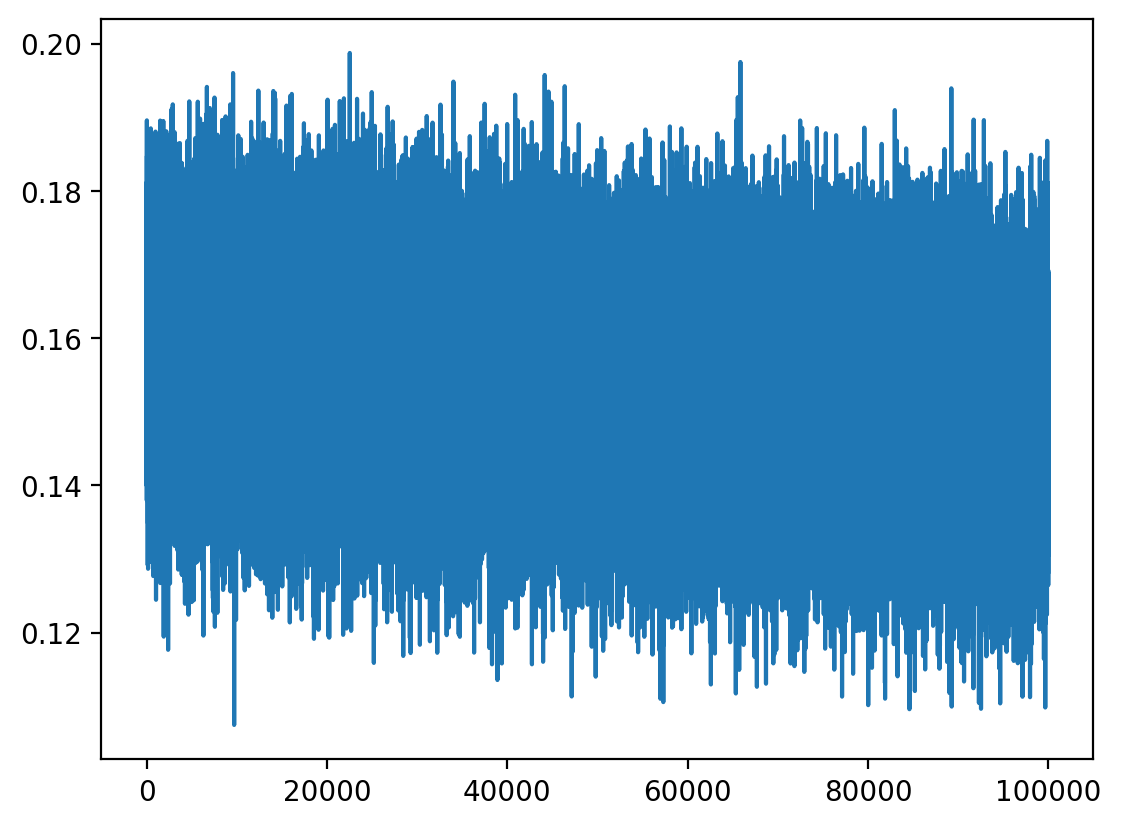

In [27]:
plt.plot(losses)

And against the validation set?

In [28]:
@torch.no_grad()
def calculate_loss(X, Y):
    logits = model(X)
    return F.cross_entropy(logits, Y)

valid_loss = calculate_loss(Xvalid, Yvalid)
print(valid_loss.item())

1.610235333442688


In [35]:
# Sampling from the model
number_of_performances = 1
model.eval()

with torch.no_grad():
    for _ in range(number_of_performances):
        out = []
        context = [vocab.pad_idx] * (block_size - 1) + [vocab.sos_idx]
        while True:
            logits = model(torch.tensor([context], device=device))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == vocab.eos_idx:
                break

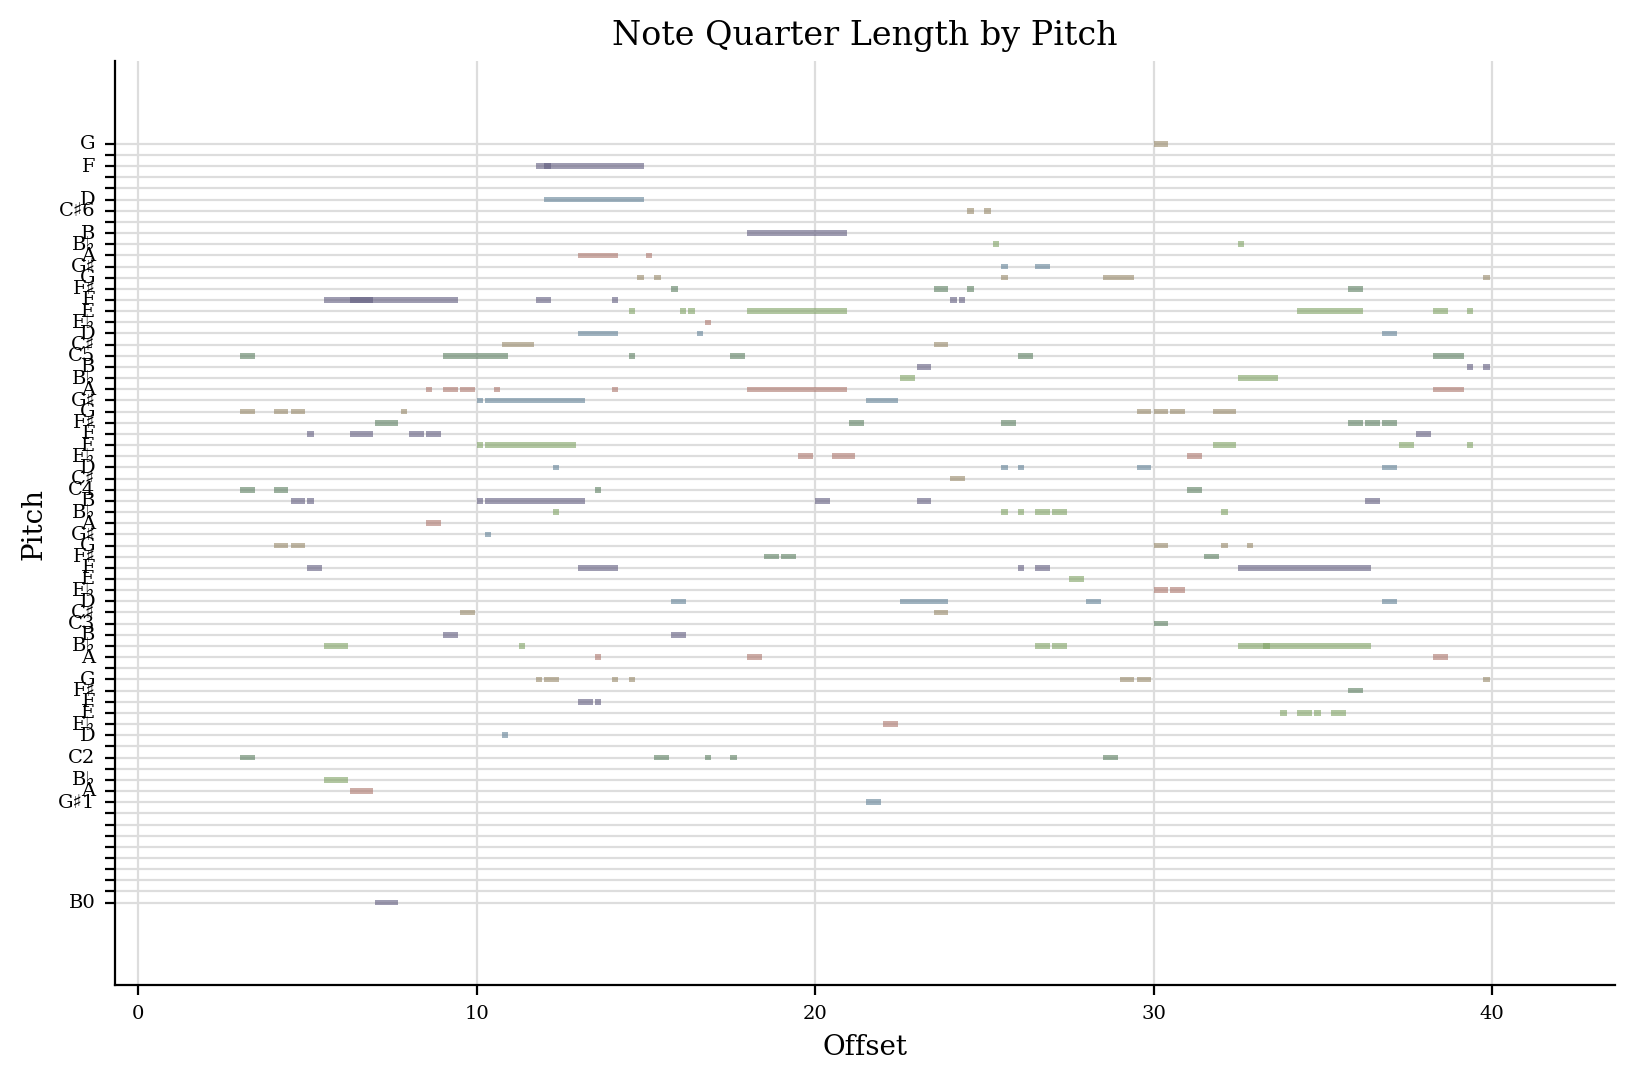

In [41]:
generated_stream = idx_to_stream_enc(np.array(out), vocab)
generated_stream.plot()

In [42]:
generated_stream.show('midi')

In [44]:
generated_stream.write('midi', 'data/midi/wavenet_generated.mid')

'data/midi/wavenet_generated.mid'